# Investigation of sentiment in Vantage articles v.2

This is a repeat of the previous analysis where the lexicon has been appended with some stock specific terms. The scores on these positive and negative terms are a flat +1 or -1 so it is more ideal for binary classification than the spectrum of polarity.

In [4]:
import csv
import pandas as pd

import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Loughran and McDonald
positive = []
with open(r'C:\Users\EdwinE\.spyder-py3\Vantage article analysis/lm_positive.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        positive.append(row[0].strip().lower())  
negative = []
with open(r'C:\Users\EdwinE\.spyder-py3\Vantage article analysis/lm_negative.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        entry = row[0].strip().split(" ")
        if len(entry) > 1:
            negative.extend([aa.lower() for aa in entry])
        else:
            negative.append(entry[0].lower())

final_lex = {}
final_lex.update({word:1.0 for word in positive})
final_lex.update({word:-1.0 for word in negative})
print(final_lex)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

##redo sentiment with new lexicon - more words but worse scaling between words
#probably more reliable for a binary classification

data = pd.read_csv('467article.csv')
data = data.drop(['Unnamed: 0'], axis =1)
output=data


HL_Vpolarity=[]
for x in data['headline']:
    HL = sia.polarity_scores(x)['compound']
    HL_Vpolarity.append(HL)
output['HL_Vpolarity'] = HL_Vpolarity
SF_Vpolarity=[]
for x in data['standfirst']:
    SF = sia.polarity_scores(x)['compound']
    SF_Vpolarity.append(SF)
output['SF_Vpolarity'] = SF_Vpolarity
text_Vpolarity = []
for x in data['text']:
    body = sia.polarity_scores(x)['compound']
    text_Vpolarity.append(body)
output['text_Vpolarity'] = text_Vpolarity

import numpy as np

sentence_pol_mean_V=[]
sentence_pol_max_V=[]
sentence_pol_min_V=[]

for x in data['text']:
    spolV=[]
    a_list = nltk.tokenize.sent_tokenize(x)
    for x in a_list:
        sent = sia.polarity_scores(x)['compound']
        spolV.append(sent)
    spolVmean=np.mean(spolV)
    spolVmax = np.max(spolV)
    spolVmin = np.min(spolV)
    sentence_pol_mean_V.append(spolVmean)
    sentence_pol_max_V.append(spolVmax)
    sentence_pol_min_V.append(spolVmin)
output['sentence_pol_mean_V'] = sentence_pol_mean_V
output['sentence_pol_max_V'] = sentence_pol_max_V
output['sentence_pol_min_V'] = sentence_pol_min_V

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-4-c05149b550eb>, line 14)

In [5]:
import pandas as pd
#import pageviews
pvdata = pd.read_csv(r'C:\Users\EdwinE\.spyder-py3\Vantage article analysis\pageviews.csv')   
output = pd.read_csv(r'C:\Users\EdwinE\.spyder-py3\Vantage article analysis\sentimentoutput3.csv')
#merge views with other data

alldata = output.merge(pvdata,on='URL')
alldata = alldata.drop(['Unnamed: 0'], axis =1)
#convert pageviews to numeric value
alldata['Pageviews'] = alldata['Pageviews'].replace({',':''},regex=True).apply(pd.to_numeric,1)

In [6]:
#we are not interested in page as it is part of URL or bounce/exit right now so drop them
alldata = alldata.drop(['Page','Bounce Rate','% Exit'],axis=1)
#view top 3 rows to see everything is in order
alldata.head(3)

,headline,date,authors,tags,standfirst,text,URL,HL_Vpolarity,SF_Vpolarity,text_Vpolarity,sentence_pol_mean_V,sentence_pol_max_V,sentence_pol_min_V,Pageviews,Unique Pageviews,Avg. Time on Page
0,Aptinyx data reveal statistical trauma,"October 20, 2020",\nElizabeth Cairns\n,"Central Nervous System,Phase II,Trial Results",An attempt to abrogate the placebo response do...,Aptinyx’s share price doubled in pre-market tr...,https://www.evaluate.com/vantage/articles/news...,-0.4215,-0.250,0.9697,0.131458,0.6073,-0.5106,281,266,00:04:04
1,Finding the next Vertex,"October 20, 2020","\nMadeleine Armstrong\n,\n Amy Brown \n,\n Edw...",Company Strategy,Other groups with large disconnects between se...,"Vertex’s $70bn market capitalisation, before i...",https://www.evaluate.com/vantage/articles/anal...,0.0000,0.000,-0.6408,0.031718,0.7430,-0.8979,435,388,00:04:17
2,US cuts fees for Covid-19 tests,"October 19, 2020",\nElizabeth Cairns\n,"Covid-19,Diagnostic,Medtech",Slower labs are to be paid less for Covid-19 t...,Last week was quiet at the US FDA when it came...,https://www.evaluate.com/vantage/articles/news...,-0.2960,-0.128,-0.9893,-0.215800,0.5267,-0.8519,192,180,00:03:27


## Initial data examination 

After an examination of the data VADER seems to be more accurate when it comes to looking at polarity 

Firstly let's look at the distribution of polarity for our Headlines and stand firsts:

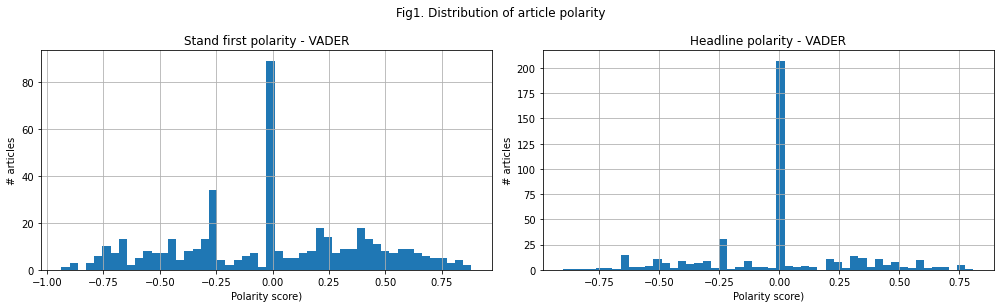

In [7]:
import matplotlib.pyplot as plt
Fig1, axes2 = plt.subplots(1, 2, figsize=(14, 4))

axes2[0] = alldata.SF_Vpolarity.hist(bins=50, ax=axes2[0])
axes2[0].set_xlabel('Polarity score)')
axes2[0].set_ylabel('# articles')
axes2[0].set_title('Stand first polarity - VADER')

axes2[1] = alldata.HL_Vpolarity.hist(bins=50, ax=axes2[1])
axes2[1].set_xlabel('Polarity score)')
axes2[1].set_ylabel('# articles')
axes2[1].set_title('Headline polarity - VADER')

Fig1.tight_layout()
Fig1.suptitle('Fig1. Distribution of article polarity', y=1.06);

We can see that many of our headlines and standfirsts are linguistically neutral with a score of 0. We seem to be very slightly skewed towards positive headlines and stand firsts. 

The body texts of our articles are in total usually very slightly positive in their language. (Note this may be due to us reporting a company's positive spin on a negative outcome, or a positive instance of a side-effect etc.)

Lets look at some of the most positive and negative stand firsts 

In [ ]:
#high positive scores
print(alldata.loc[alldata['SF_Vpolarity'] >0.75, 'standfirst'].head(3))

In [8]:
#high negative scores
print(alldata.loc[alldata['SF_Vpolarity'] <-0., 'standfirst'].head(3))

0    An attempt to abrogate the placebo response do...
2    Slower labs are to be paid less for Covid-19 t...
3    A global pandemic has done nothing to crimp M&...
Name: standfirst, dtype: object


Looking at the body text 

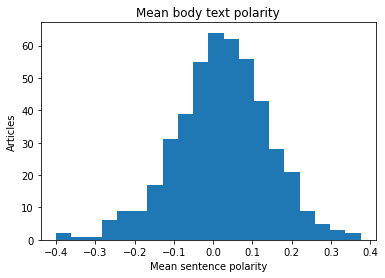

In [9]:
plt.figure()
plt.hist(alldata['sentence_pol_mean_V'],bins=20)
plt.ylabel('Articles')
plt.xlabel('Mean sentence polarity')
plt.title('Mean body text polarity')
plt.show()

Our article text on average appears to trends towards positive language

The subjectivity analysis doesn't seem to have worked as well as the polarity score. So we should not pay too much attention to this going forward. 

Next lets look at the number of pageviews:

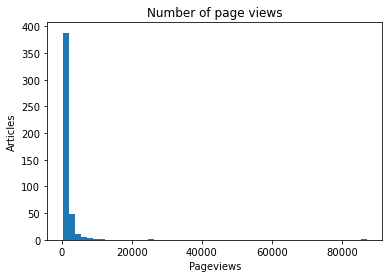

In [10]:
plt.figure()
plt.hist(alldata['Pageviews'],bins=50)
plt.ylabel('Articles')
plt.xlabel('Pageviews')
plt.title('Number of page views')
plt.show()

We appear to have a large outlier in the data. Let's view the data with any points above or below 3* the standard deviation removed.

In [11]:
import numpy
from numpy import mean
from numpy import std
data_mean, data_std = mean(alldata['Pageviews']), std(alldata['Pageviews'])
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
outliers_removed = alldata[alldata.Pageviews < upper]

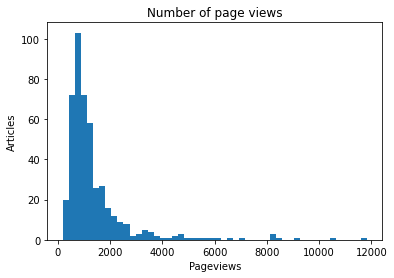

In [12]:
plt.figure()
plt.hist(outliers_removed['Pageviews'],bins=50)
plt.ylabel('Articles')
plt.xlabel('Pageviews')
plt.title('Number of page views')
plt.show()

Next let's look at the pageviews vs. the date of publication to see if the age of the article makes a meaningful difference to the pageviews. Calculated date difference from today in days.

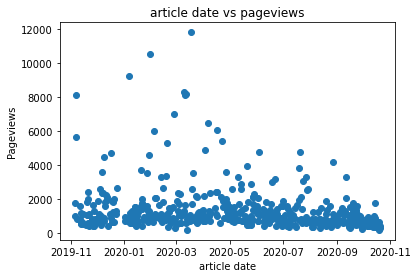

In [13]:
import datetime
outliers_removed['date'] = pd.to_datetime(outliers_removed['date'])
outliers_removed['date_difference'] = datetime.datetime.now() - outliers_removed['date']
datediff=[]
for x in outliers_removed['date_difference']:
    nodays = x.days
    datediff.append(nodays)
outliers_removed['date_difference_days'] = datediff
plt.scatter(outliers_removed['date'],outliers_removed['Pageviews'])
plt.xlabel("article date")
plt.ylabel("Pageviews")
plt.title("article date vs pageviews")
plt.show()

There appears to be a weak association with article age although not confirmed. We will however drop the newest articles that are less than a week old to be safe.

In [14]:
outliers_removed['SF_distance_from_0'] = abs(0-outliers_removed['SF_Vpolarity'])
outliers_removed['HL_distance_from_0'] = abs(0-outliers_removed['HL_Vpolarity'])
outliers_removed['text_distance_from_0'] = abs(0-outliers_removed['sentence_pol_mean_V'])

In [15]:
Newdrop = outliers_removed[(outliers_removed['date'] < '2020-10-01')]

Text(0.5, 0.92, 'Figure 4. Listings Numerical Features Cross-Correlation Matrix')

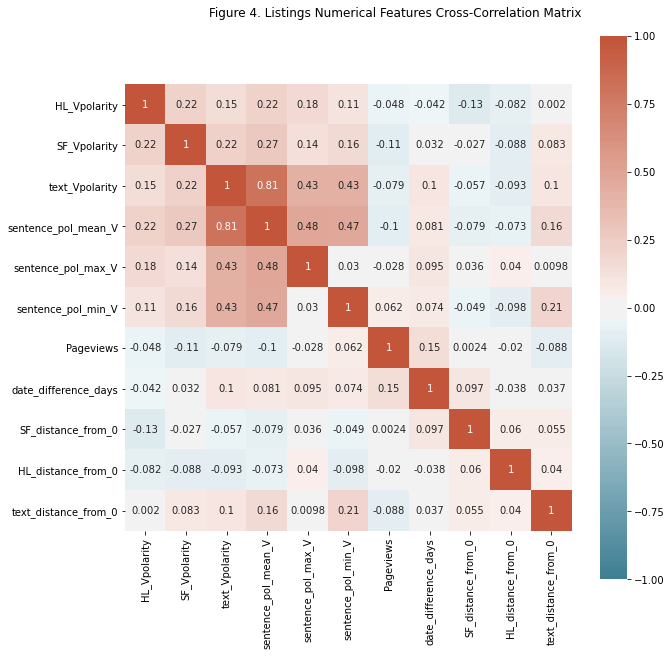

In [16]:
import seaborn as sns
import numpy as np
fig4, ax4 = plt.subplots(figsize=(10, 10))
ax4 = sns.heatmap(Newdrop.select_dtypes(include=np.number).corr(), ax=ax4,
                  vmin=-1, vmax=1, center=0, annot=True, square=True,
                  cmap=sns.diverging_palette(220, 20, n=200))
fig4.suptitle('Figure 4. Listings Numerical Features Cross-Correlation Matrix', y=0.92)

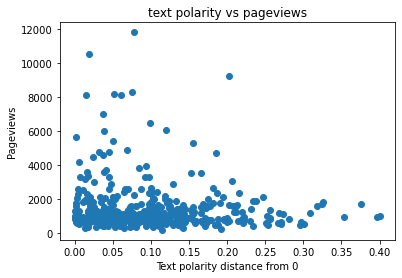

In [17]:
plt.scatter(Newdrop['text_distance_from_0'],Newdrop['Pageviews'])
plt.xlabel("Text polarity distance from 0")
plt.ylabel("Pageviews")
plt.title("text polarity vs pageviews")
plt.show()

Although the correlation is weak, there does appear to be something there so lets, see if it is statistically significant:

In [18]:
from scipy import stats
stats.pearsonr(Newdrop['text_distance_from_0'], Newdrop['Pageviews'])

(-0.08803297680595563, 0.0672339735308475)

Okay, it appears to be a weak but significant correlation. This however could be a function of a large sample size. To check this we will randomly sample 50 stories and see if the correlation/sign

In [19]:

corrav=[]
for x in range(1,10):
    smallsamp = Newdrop.sample(50)
    corrav.append(stats.pearsonr(smallsamp['text_distance_from_0'], smallsamp['Pageviews'])[1])
np.mean(corrav)    


0.4619391548052192

It appears that it may indeed be function of N that is making the text polarity significant.

Next will look at author stats, mainly for interest.

Firsly split the dataset by author

In [20]:
JP = Newdrop[Newdrop['authors'].str.contains("Jacob")]
AB = Newdrop[Newdrop['authors'].str.contains("Amy")]
MA = Newdrop[Newdrop['authors'].str.contains("Madeleine")]
LU = Newdrop[Newdrop['authors'].str.contains("Lisa")]
LC = Newdrop[Newdrop['authors'].str.contains("Elizabeth")]

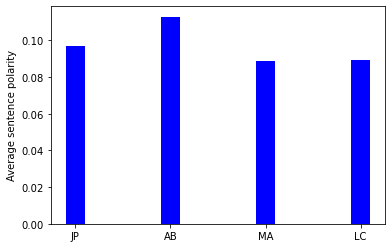

In [21]:
y = [np.mean(JP['text_distance_from_0']),np.mean(AB['text_distance_from_0']),np.mean(MA['text_distance_from_0']),np.mean(LC['text_distance_from_0'])]
plt.bar(np.arange(4), y, width=0.2, color='b')
plt.xticks(np.arange(4), ('JP', 'AB', 'MA', 'LC'))
plt.ylabel('Average sentence polarity')
plt.show()

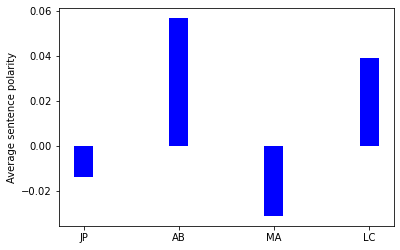

In [22]:
y = [np.mean(JP['sentence_pol_mean_V']),np.mean(AB['sentence_pol_mean_V']),np.mean(MA['sentence_pol_mean_V']),np.mean(LC['sentence_pol_mean_V'])]
plt.bar(np.arange(4), y, width=0.2, color='b')
plt.xticks(np.arange(4), ('JP', 'AB', 'MA', 'LC'))
plt.ylabel('Average sentence polarity')
plt.show()

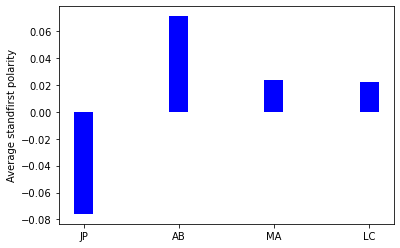

In [23]:
y = [np.mean(JP['SF_Vpolarity']),np.mean(AB['SF_Vpolarity']),np.mean(MA['SF_Vpolarity']),np.mean(LC['SF_Vpolarity'])]
plt.bar(np.arange(4), y, width=0.2, color='b')
plt.xticks(np.arange(4), ('JP', 'AB', 'MA', 'LC'))
plt.ylabel('Average standfirst polarity')
plt.show()

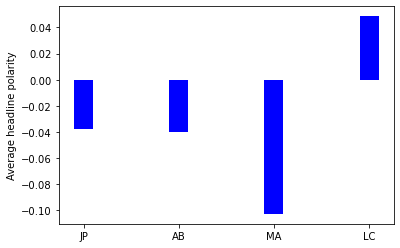

In [24]:
y = [np.mean(JP['HL_Vpolarity']),np.mean(AB['HL_Vpolarity']),np.mean(MA['HL_Vpolarity']),np.mean(LC['HL_Vpolarity'])]
plt.bar(np.arange(4), y, width=0.2, color='b')
plt.xticks(np.arange(4), ('JP', 'AB', 'MA', 'LC'))
plt.ylabel('Average headline polarity')
plt.show()


Some pretty big differences in headline polarity, lets plot the distributions. Have to remember Mads has been off so will have less 0 polarity headlines centering her polarity (As 0 seems to be the norm).

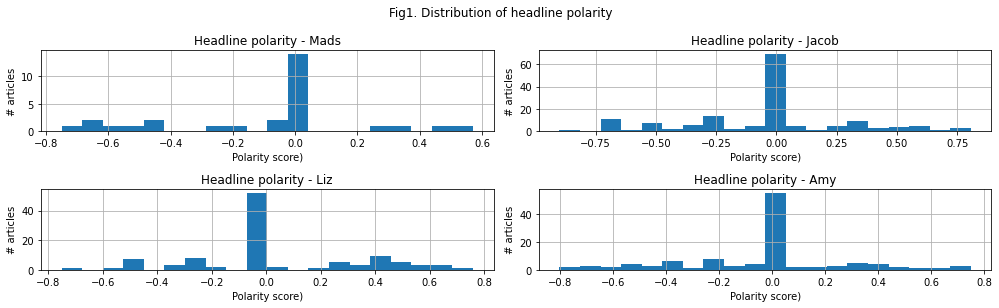

In [25]:
import matplotlib.pyplot as plt
Fig1, axes2 = plt.subplots(2, 2, figsize=(14, 4))

axes2[0,0] = MA.HL_Vpolarity.hist(bins=20, ax=axes2[0,0])
axes2[0,0].set_xlabel('Polarity score)')
axes2[0,0].set_ylabel('# articles')
axes2[0,0].set_title('Headline polarity - Mads')

axes2[1,0] = LC.HL_Vpolarity.hist(bins=20, ax=axes2[1,0])
axes2[1,0].set_xlabel('Polarity score)')
axes2[1,0].set_ylabel('# articles')
axes2[1,0].set_title('Headline polarity - Liz')

axes2[0,1] = JP.HL_Vpolarity.hist(bins=20, ax=axes2[0,1])
axes2[0,1].set_xlabel('Polarity score)')
axes2[0,1].set_ylabel('# articles')
axes2[0,1].set_title('Headline polarity - Jacob')

axes2[1,1] = AB.HL_Vpolarity.hist(bins=20, ax=axes2[1,1])
axes2[1,1].set_xlabel('Polarity score)')
axes2[1,1].set_ylabel('# articles')
axes2[1,1].set_title('Headline polarity - Amy')

Fig1.tight_layout()
Fig1.suptitle('Fig1. Distribution of headline polarity', y=1.06);

Lets also do standfirst as at the topline this is the most spread of our texts and Jacob was an anomology in this one.

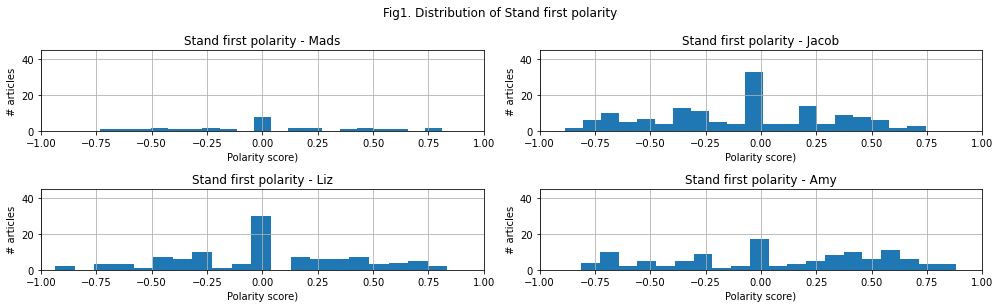

In [26]:
import matplotlib.pyplot as plt
Fig1, axes2 = plt.subplots(2, 2, figsize=(14, 4))
axes2[0,0] = MA.SF_Vpolarity.hist(bins=20, ax=axes2[0,0])
axes2[0,0].set_xlabel('Polarity score)')
axes2[0,0].set_ylabel('# articles')
axes2[0,0].set_xlim(-1,1)
axes2[0,0].set_ylim(0,45)
axes2[0,0].set_title('Stand first polarity - Mads')

axes2[1,0] = LC.SF_Vpolarity.hist(bins=20, ax=axes2[1,0])
axes2[1,0].set_xlabel('Polarity score)')
axes2[1,0].set_ylabel('# articles')
axes2[1,0].set_xlim(-1,1)
axes2[1,0].set_ylim(0,45)
axes2[1,0].set_title('Stand first polarity - Liz')

axes2[0,1] = JP.SF_Vpolarity.hist(bins=20, ax=axes2[0,1])
axes2[0,1].set_xlabel('Polarity score)')
axes2[0,1].set_ylabel('# articles')
axes2[0,1].set_xlim(-1,1)
axes2[0,1].set_ylim(0,45)
axes2[0,1].set_title('Stand first polarity - Jacob')

axes2[1,1] = AB.SF_Vpolarity.hist(bins=20, ax=axes2[1,1])
axes2[1,1].set_xlabel('Polarity score)')
axes2[1,1].set_ylabel('# articles')
axes2[1,1].set_xlim(-1,1)
axes2[1,1].set_ylim(0,45)
axes2[1,1].set_title('Stand first polarity - Amy')

Fig1.tight_layout()
Fig1.suptitle('Fig1. Distribution of Stand first polarity', y=1.06);

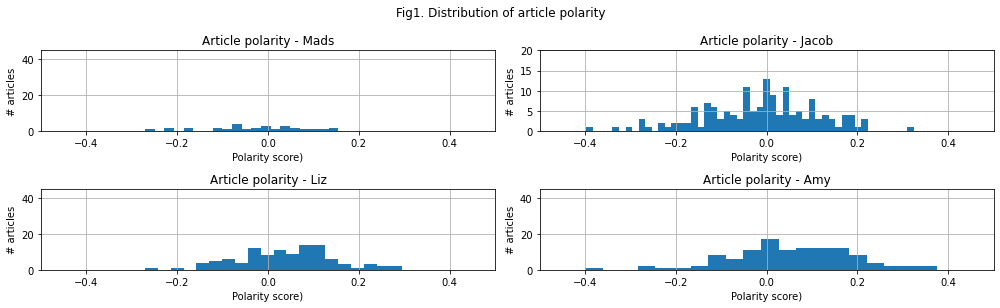

In [30]:
import matplotlib.pyplot as plt
Fig1, axes2 = plt.subplots(2, 2, figsize=(14, 4))
axes2[0,0] = MA.sentence_pol_mean_V.hist(bins=20, ax=axes2[0,0])
axes2[0,0].set_xlabel('Polarity score)')
axes2[0,0].set_ylabel('# articles')
axes2[0,0].set_xlim(-0.5,0.5)
axes2[0,0].set_ylim(0,45)
axes2[0,0].set_title('Article polarity - Mads')

axes2[1,0] = LC.sentence_pol_mean_V.hist(bins=20, ax=axes2[1,0])
axes2[1,0].set_xlabel('Polarity score)')
axes2[1,0].set_ylabel('# articles')
axes2[1,0].set_xlim(-0.5,0.5)
axes2[1,0].set_ylim(0,45)
axes2[1,0].set_title('Article polarity - Liz')

axes2[0,1] = JP.sentence_pol_mean_V.hist(bins=50, ax=axes2[0,1])
axes2[0,1].set_xlabel('Polarity score)')
axes2[0,1].set_ylabel('# articles')
axes2[0,1].set_xlim(-0.5,0.5)
axes2[0,1].set_ylim(0,20)
axes2[0,1].set_title('Article polarity - Jacob')

axes2[1,1] = AB.sentence_pol_mean_V.hist(bins=20, ax=axes2[1,1])
axes2[1,1].set_xlabel('Polarity score)')
axes2[1,1].set_ylabel('# articles')
axes2[1,1].set_xlim(-0.5,0.5)
axes2[1,1].set_ylim(0,45)
axes2[1,1].set_title('Article polarity - Amy')

Fig1.tight_layout()
Fig1.suptitle('Fig1. Distribution of article polarity', y=1.06);